In [30]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pylab as pl
%matplotlib inline
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA

# What did the data look like originally?

In [6]:
# Load the original data set - BEFORE transformations
original_data = pd.read_csv('original_data.csv')
original_data['Date'] = pd.to_datetime(original_data['Date'], infer_datetime_format=True)

# Display
original_data.head()

,Unnamed: 0,Date,Start_Station_Capacity,Station_Number,Status,Bike_Count,Count_Percent_Capacity
0,24,2015-07-01 08:25:00,19.0,31116,add bike,1.0,5.263158
1,26,2015-07-01 08:26:00,19.0,31116,subtract bike,0.0,0.000000
2,28,2015-07-01 09:42:00,19.0,31116,add bike,1.0,5.263158
3,30,2015-07-01 09:55:00,19.0,31116,subtract bike,0.0,0.000000
4,32,2015-07-01 10:38:00,19.0,31116,add bike,1.0,5.263158


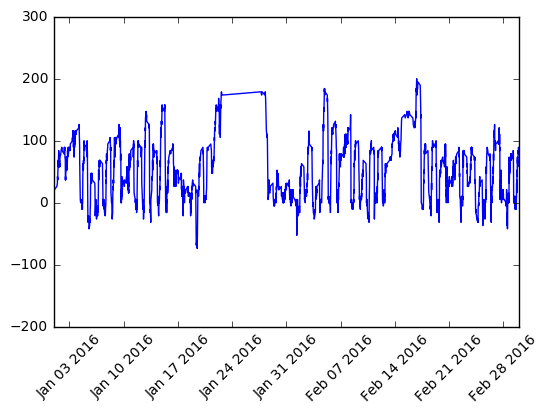

In [8]:
# For a random, specific station, 31116, what did the time series look like?
original_data_31116 = original_data[original_data['Station_Number'] == 31116]

plt.plot(original_data_31116['Date'], original_data_31116['Count_Percent_Capacity'])
plt.ylim(-200, 300)
plt.xlim('2016-01-01 00:00:00', '2016-03-01 00:00:00') # Random months to show snapshot
plt.xticks(rotation=45);

# What does the data look like after transformations?

In [10]:
# Load the new, transformed data set
transformed_data = pd.read_csv('transformed_data.csv')
transformed_data['Date'] = pd.to_datetime(transformed_data['Date'], infer_datetime_format=True)

# Display
transformed_data.head()

,Unnamed: 0,Date,Station_Number,Count_Percent_Capacity
0,0,2015-07-01 08:25:00,31116,5.263158
1,1,2015-07-01 08:26:00,31116,0.000000
2,2,2015-07-01 09:42:00,31116,5.263158
3,3,2015-07-01 09:55:00,31116,0.000000
4,4,2015-07-01 10:38:00,31116,5.263158


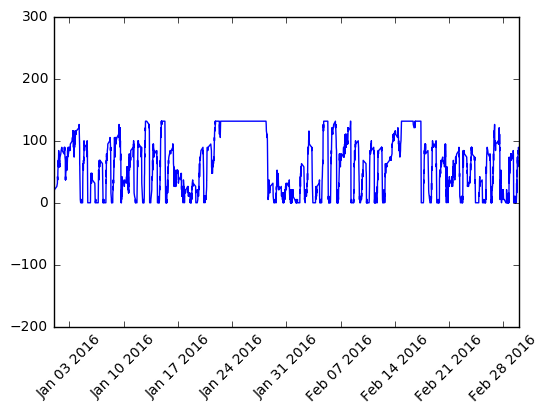

In [13]:
# For a random, specific station, 31116, what did the time series look like?
transformed_data_31116 = transformed_data[transformed_data['Station_Number'] == 31116]

plt.plot(transformed_data_31116['Date'], transformed_data_31116['Count_Percent_Capacity'])
plt.ylim(-200, 300)
plt.xlim('2016-01-01 00:00:00', '2016-03-01 00:00:00') # Random months to show snapshot
plt.xticks(rotation=45);

# Try an ARIMA model on the transformed data for station 31116

In [16]:
# Take the subset of transformed data for station 31116 as a series object
series_31116 = transformed_data_31116[['Date', 'Count_Percent_Capacity']]
series_31116.set_index('Date', inplace=True)
series_31116 = series_31116['Count_Percent_Capacity']

# Display
series_31116 .head()

Date
2015-07-01 08:25:00    5.263158
2015-07-01 08:26:00    0.000000
2015-07-01 09:42:00    5.263158
2015-07-01 09:55:00    0.000000
2015-07-01 10:38:00    5.263158
Name: Count_Percent_Capacity, dtype: float64

In [20]:
# Create function for stationarity test
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.DataFrame.rolling(timeseries, window=12,center=False).mean()
    rolstd = pd.DataFrame.rolling(timeseries, window=12,center=False).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

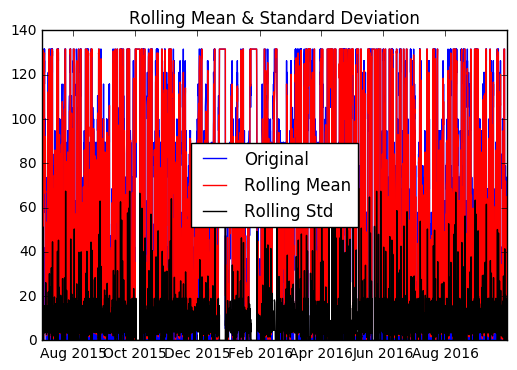

Results of Dickey-Fuller Test:
Test Statistic                   -28.408636
p-value                            0.000000
#Lags Used                        28.000000
Number of Observations Used    50807.000000
Critical Value (10%)              -2.566800
Critical Value (1%)               -3.430479
Critical Value (5%)               -2.861597
dtype: float64


In [21]:
# Run a test for stationarity on series_31116
test_stationarity(series_31116)

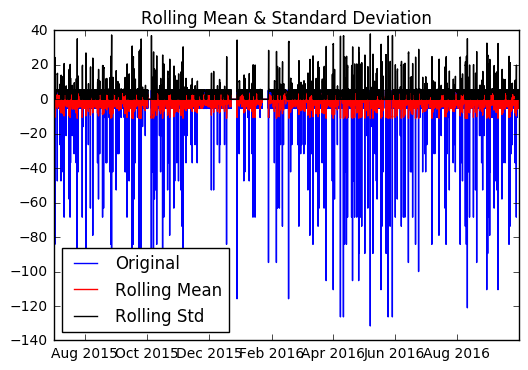

Results of Dickey-Fuller Test:
Test Statistic                   -40.279677
p-value                            0.000000
#Lags Used                        57.000000
Number of Observations Used    50777.000000
Critical Value (10%)              -2.566800
Critical Value (1%)               -3.430479
Critical Value (5%)               -2.861597
dtype: float64


In [22]:
# Dickey_Fuller Test above shows that the series is stationary

# Induce further stationarity by differencing
series_31116_diff = series_31116 - series_31116.shift()
series_31116_diff.dropna(inplace=True)

# Run another test for stationarity on the differenced series
test_stationarity(series_31116_diff)

In [23]:
# Above test for stationarity shows that differenced series is even more stationary. As expected.

In [24]:
# Create ACF and PACF plots as inputs to the ARIMA model
lag_pacf = pacf(series_31116_diff, nlags=20, method='ols')

(-0.05, 0.05)

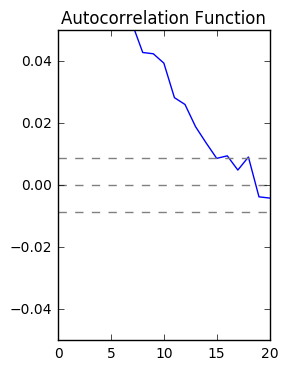

In [27]:
# Plot ACF: 
lag_acf = acf(series_31116_diff, nlags=20)
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(series_31116_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(series_31116_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
plt.ylim(-.05, .05)

(-0.05, 0.05)

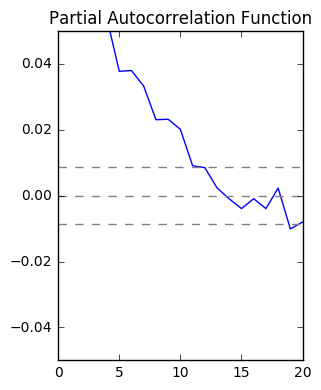

In [29]:
# Plot PACF:
lag_pacf = pacf(series_31116_diff, nlags=20, method='ols')
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(series_31116_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(series_31116_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()
plt.ylim(-.05, .05)

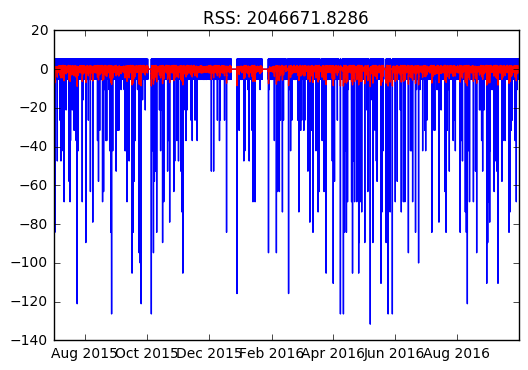

In [33]:
# AR Model
model = ARIMA(series_31116, order=(11, 1, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(series_31116_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-series_31116_diff)**2))

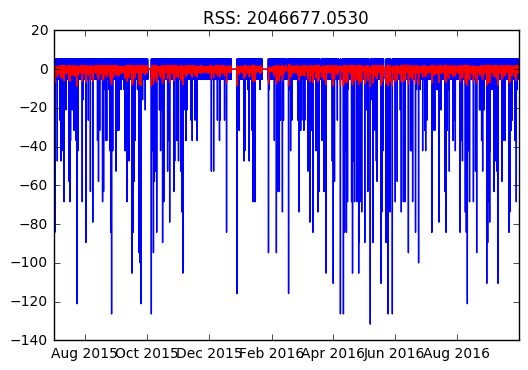

In [35]:
# MA Model
model = ARIMA(series_31116, order=(0, 1, 15))  
results_MA = model.fit(disp=-1)  
plt.plot(series_31116_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-series_31116_diff)**2))

In [36]:
# Combined ARIMA Model
model = ARIMA(series_31116, order=(11, 1, 15))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(series_31116_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-series_31116_diff)**2))

ValueError: The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.